In [3]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Model is not converging.  Current: 15.05172948837712 is not greater than 15.055280327770443. Delta is -0.003550839393323457
Model is not converging.  Current: 19.262796364802963 is not greater than 19.262797124491204. Delta is -7.596882412030936e-07
Model is not converging.  Current: 0.0039001978905892076 is not greater than 0.013733948821504027. Delta is -0.00983375093091482
Model is not converging.  Current: -1.4840770401641583 is not greater than -1.4840762247774626. Delta is -8.153866957183453e-07
Model is not converging.  Current: -2.182096124073856 is not greater than -2.170644946986839. Delta is -0.01145117708701715
Model is not converging.  Current: 19.262796766338322 is not greater than 19.262824648065685. Delta is -2.7881727362455422e-05
Model is not converging.  Current: 14.341706355402073 is not greater than 14.342334917104711. Delta is -0.000628561702638919
Model is not converging.  Current: 15.794436582290498 is not greater than 15.794582369879056. Delta is -0.00014578758

En iyi sonuç veren random_seed: 347 ile Son Bakiye: 13600.00


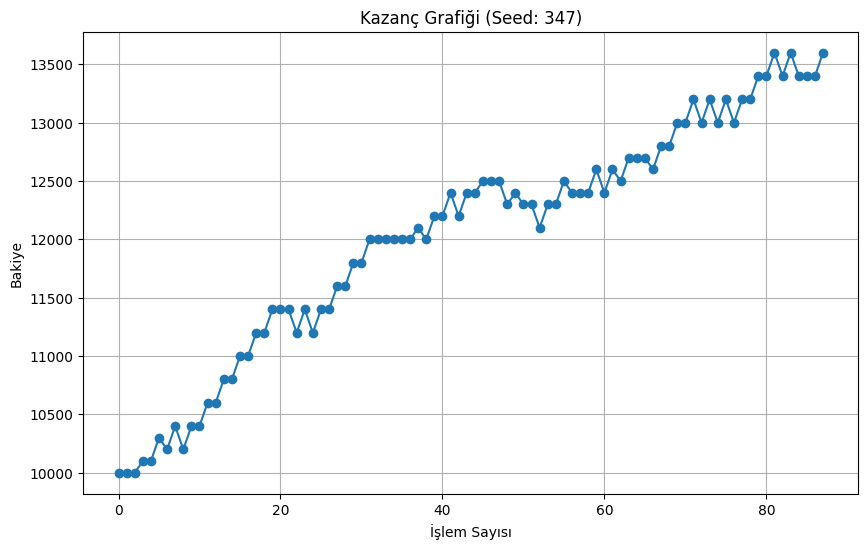

In [ ]:
def rolling_hmm_strategy(data, window_size=20, initial_balance=10000, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    balance = initial_balance
    position = 0  # Pozisyon (0: Nötr, 1: Long, -1: Short)
    profit_history = []
    
    state_labels = ["Boğa (Yükseliş)", "Ayı (Düşüş)", "Yatay (Kararsız)"]

    for i in range(len(data) - window_size - 1):
        train_data = data[i:i+window_size].reshape(-1, 1)
        
        # HMM modelini eğit
        model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=1500, init_params="stmc")
        model.fit(train_data)
        
        # Günlük tahmini yap
        hidden_states = model.predict(train_data)
        last_observation = train_data[-1][0]
        posteriors = model.predict_proba(np.array([[last_observation]]))
        next_state = np.argmax(posteriors)

        # Trade stratejisi: 
        if next_state == 0:  # Boğa (Long Aç)
            if position == 0:
                position = 1
                entry_price = data[i+window_size]
            elif position == -1:
                exit_price = data[i+window_size]
                profit = (exit_price - entry_price) * position * 100  # 100 birimlik işlem
                balance += profit
                profit_history.append(balance)
                position = 1
        elif next_state == 1:  # Ayı (Short Aç)
            if position == 0:
                position = -1
                entry_price = data[i+window_size]
            elif position == 1:
                exit_price = data[i+window_size]
                profit = (exit_price - entry_price) * position * 100  # 100 birimlik işlem
                balance += profit
                profit_history.append(balance)
                position = -1
    
    return balance, profit_history

#veriyi yükle
result = np.load("result.npy")
data = np.zeros(len(result))
for i in range(len(result)):
    if result[i] == 'bull':
        data[i] = 0
    elif result[i] == 'horizontal':
        data[i] = 1
    else:
        data[i] = 2
data = data[0:365]

# Optimum seed değerini bulma
best_balance = 0
best_seed = None

for seed in range(0, 500):
    final_balance, _ = rolling_hmm_strategy(data, window_size=20, random_seed=seed)
    if final_balance > best_balance:
        best_balance = final_balance
        best_seed = seed

print(f"En iyi sonuç veren random_seed: {best_seed} ile Son Bakiye: {best_balance:.2f}")

# Optimum seed için stratejiyi tekrar çalıştırarak kazanç geçmişini alıyoruz
final_balance, profit_history = rolling_hmm_strategy(data, window_size=20, random_seed=best_seed)

# Kazanç grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(profit_history, marker='o')
plt.title(f"Kazanç Grafiği (Seed: {best_seed})")
plt.xlabel("İşlem Sayısı")
plt.ylabel("Bakiye")
plt.grid(True)
plt.show()



En iyi sonuç veren random_seed: 347 ile Son Bakiye: 13600.00

#14200.edfs47
#71
#198 de 32